##Introduction and Environment Setup

In [ ]:
%%capture

# First ensure DASCore is installed. If not, install and restart the kernel.
try:
    import dascore as dc
except ImportError:
    !pip install dascore
    !pip install ipympl
    # resetart kernel
    import IPython
    IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel


import numpy as np
from rich import print

In [ ]:
import numpy as np

import dascore as dc
from dascore.utils.time import to_timedelta64

In [ ]:
dc.__version__

'0.1.6'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##3 ways to create a spool  
We can use dc.spool() to make a spool from:  
  * A single file  
  * A list of patches  
  * A directory of files

The cell below should prepare the path to our data and data folder.  
You'll need to change the das_folder_path to the path for your data (either locally or on Google Drive). If you're pulling data from Google Drive, you'll need to make a shortcut to the directory you're referring to.  
If your shortcut of "Example_data" is in "MyDrive", then you can use the cell below directly.

In [ ]:
das_folder_path = "drive/MyDrive/Example_data/AtoG_Spool_example_data"
das_file_path = "drive/MyDrive/Example_data/AtoG_Spool_example_data/patch1.h5"

From a single file

In [ ]:
spool = dc.spool(das_file_path)
patch = spool[0]

From a list of patches

In [ ]:
spool = dc.spool([patch])

From a directory of files

In [ ]:
spool = dc.spool(das_folder_path)

What is contained in this spool?

In [ ]:
spool

DASCore DirectorySpool 🧵 (3 Patches)
    Path: /content/drive/MyDrive/Example_data/AtoG_Spool_example_data

This spool contains 3 patches (3 data files from the folder path)  
You can use "spool.get_contents()" to display the metadata.  

In [ ]:
contents = spool.get_contents()

display(contents)

,network,dims,tag,time_min,time_max,data_type,data_category,instrument_id,path,file_format,time_step,file_version,station,experiment_id,_modified
0,,"time,distance",,2022-04-21 05:56:34.998177,2022-04-21 05:56:36.997927,strain_rate,,01CE1469,patch3.h5,DASDAE,0 days 00:00:00.000250,1,,,False
1,,"time,distance",,2022-04-21 05:56:36.998177,2022-04-21 05:56:37.997927,strain_rate,,01CE1469,patch2.h5,DASDAE,0 days 00:00:00.000250,1,,,False
2,,"time,distance",,2022-04-21 05:56:37.998177,2022-04-21 05:56:38.997927,strain_rate,,01CE1469,patch1.h5,DASDAE,0 days 00:00:00.000250,1,,,False


According to "spool.get_contents()", the 3 patchea we prepared have a time span of:  
$\begin{array}{|c|c|c|}
\hline
\textbf{path} & \textbf{time_min} & \textbf{time_max} \\
\hline
\texttt{patch3.h5} & \texttt{2022-04-21 05:56:34.998177} & \texttt{2022-04-21 05:56:36.997927} \\
\texttt{patch2.h5} & \texttt{2022-04-21 05:56:36.998177} & \texttt{2022-04-21 05:56:37.997927} \\
\texttt{patch1.h5} & \texttt{2022-04-21 05:56:37.998177} & \texttt{2022-04-21 05:56:38.997927} \\
\hline
\end{array}$  
The three files follow one another in time.  

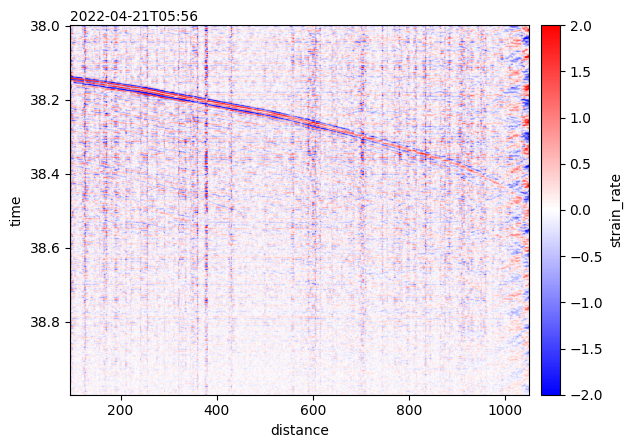

<Axes: xlabel='distance', ylabel='time'>

In [ ]:
#you can access a Patch in a Spool just as you would access an object in a list
spool[2].viz.waterfall(show=True,scale=(-2.0,2.0))#the third patch contains a seismic event

##Map
Use the map method apply a function to all patches in a spool

In [ ]:
def sta_lta(patch, sta_window, lta_window):
    """
    Compute the non-recursive STA/LTA ratio for a DASCore Patch object.

    Parameters:
    -----------
    patch : dascore.core.Patch
        The DASCore Patch object containing the time-series data.
    sta_window : int
        Window size (in samples) for the Short-Term Average.
    lta_window : int
        Window size (in samples) for the Long-Term Average.

    Returns:
    --------
    sta_lta_patch : dascore.core.Patch
        A new Patch object containing the STA/LTA ratio.
    """
    # Extract data
    data = patch.data

    # Compute the squared values
    patch_square = patch.new(data=np.square(data), attrs=patch.attrs)

    # Compute Short-Term Average (STA) and Long-Term Average (LTA) using DASCore rolling function
    sta = patch_square.rolling(time=sta_window,samples =True).mean().data
    lta = patch_square.rolling(time=lta_window,samples =True).mean().data

    # Avoid division by zero in LTA
    with np.errstate(divide='ignore', invalid='ignore'):
        sta_lta_ratio = np.where(lta > 0, sta / lta, 0)

    # Create a new Patch with the STA/LTA ratio
    sta_lta_patch = patch.new(data=sta_lta_ratio, attrs=patch.attrs)

    return sta_lta_patch.update_attrs(data_type = 'sta_lta') #update data_type

Apply sta_lta function to all patches in the spool. The sta_window and lta_window will be passed to sta_lta function as keyword arguments.   
The function you want to map must be a callable function which takes a patch as its first argument.

In [ ]:
#sta_window: 0.1s, lta_window: 0.5s
map_stalta = spool.map(sta_lta,sta_window=400,lta_window=2000, progress=False)
#The ‘progress’ argument controls whether to display the progress bar

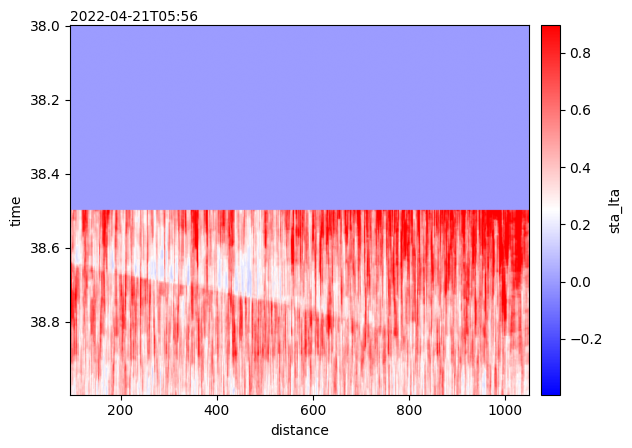

<Axes: xlabel='distance', ylabel='time'>

In [ ]:
map_stalta[2].viz.waterfall(show=True, scale=0.8)

The STA/LTA trace has an inherent delay equal to the LTA window length, so the first 0.5s has no effective output.  
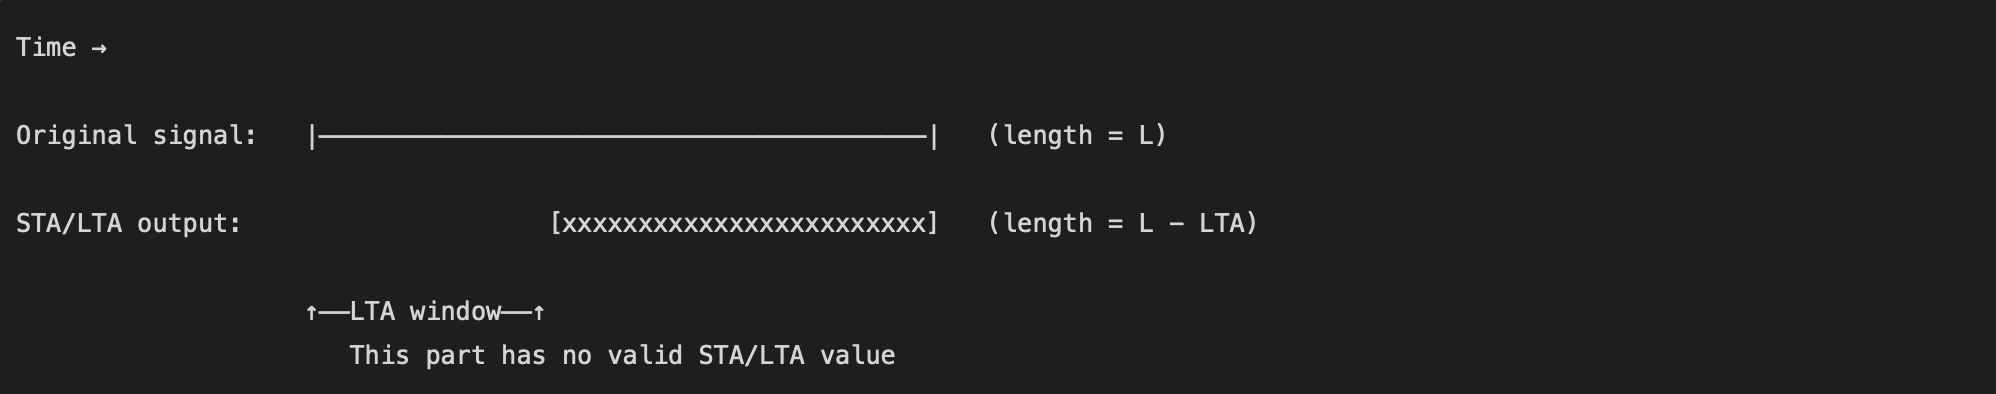

##Chunk
Chunk the data in the spool along specified dimension

In [ ]:
subspool=spool.chunk(time=2, overlap=1)

In [ ]:
subspool.get_contents()

,time_min,time_max,time_step,data_category,experiment_id,data_type,instrument_id,station,tag,dims,network,_group
0,2022-04-21 05:56:34.998177,2022-04-21 05:56:36.997927,0 days 00:00:00.000250,,,strain_rate,01CE1469,,,"time,distance",,0_0_0
1,2022-04-21 05:56:35.998177,2022-04-21 05:56:37.997927,0 days 00:00:00.000250,,,strain_rate,01CE1469,,,"time,distance",,0_0_0
2,2022-04-21 05:56:36.998177,2022-04-21 05:56:38.997927,0 days 00:00:00.000250,,,strain_rate,01CE1469,,,"time,distance",,0_0_0


Map the stalta function to chunked spool

In [ ]:
map_stalta = spool.chunk(time=2, overlap=1).map(sta_lta,sta_window=400,lta_window=2000, progress=False)

By using overlapping signal segments, each segment produces a valid STA/LTA trace without losing the initial portion due to windowing effects.

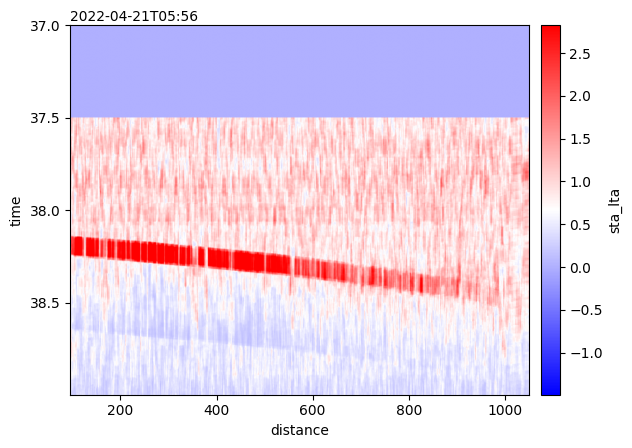

<Axes: xlabel='distance', ylabel='time'>

In [ ]:
map_stalta[2].viz.waterfall(show=True, scale=1.0)

## Selecting  
The cell below will create a new spool. We only care about the das2 and das3 network pieces of the directory's contents, so we'll look at the original contents, select, and look at the reduced contents in the subspool after selecting.

In [33]:
in_memory_spool = dc.get_example_spool("diverse_das")

das_folder_path = dc.examples.spool_to_directory(in_memory_spool)
spool = dc.spool(das_folder_path)

In [34]:
contents = spool.get_contents()

display(contents)

,data_category,experiment_id,time_step,data_type,time_max,file_version,instrument_id,station,file_format,tag,time_min,dims,network,path,_modified
0,,,0 days 00:00:00.004000,,1989-05-04 00:00:07.996,1,,wayout,DASDAE,random,1989-05-04 00:00:00.000,"distance,time",,DAS_____wayout__random__1989_05_04__1989_05_04...,False
1,,,0 days 00:00:00.004000,,2020-01-03 00:00:07.996,1,,,DASDAE,random,2020-01-03 00:00:00.000,"distance,time",,DAS_______random__2020_01_03__2020_01_03T00_00...,False
2,,,0 days 00:00:00.004000,,2020-01-03 00:00:07.996,1,,overlaps,DASDAE,random,2020-01-03 00:00:00.000,"distance,time",,DAS_____overlaps__random__2020_01_03__2020_01_...,False
3,,,0 days 00:00:00.004000,,2020-01-03 00:00:07.996,1,,smallg,DASDAE,random,2020-01-03 00:00:00.000,"distance,time",,DAS_____smallg__random__2020_01_03__2020_01_03...,False
4,,,0 days 00:00:00.004000,,2020-01-03 00:00:07.996,1,,big_gaps,DASDAE,random,2020-01-03 00:00:00.000,"distance,time",,DAS_____big_gaps__random__2020_01_03__2020_01_...,False
5,,,0 days 00:00:00.004000,,2020-01-03 00:00:07.996,1,,,DASDAE,random,2020-01-03 00:00:00.000,"distance,time",das2,DAS___das2____random__2020_01_03__2020_01_03T0...,False
6,,,0 days 00:00:00.004000,,2020-01-03 00:00:07.996,1,,,DASDAE,some_tag,2020-01-03 00:00:00.000,"distance,time",,DAS_______some_tag__2020_01_03__2020_01_03T00_...,False
7,,,0 days 00:00:00.004000,,2020-01-03 00:00:15.986,1,,overlaps,DASDAE,random,2020-01-03 00:00:07.990,"distance,time",,DAS_____overlaps__random__2020_01_03T00_00_07_...,False
8,,,0 days 00:00:00.004000,,2020-01-03 00:00:15.996,1,,,DASDAE,random,2020-01-03 00:00:08.000,"distance,time",,DAS_______random__2020_01_03T00_00_08__2020_01...,False
9,,,0 days 00:00:00.004000,,2020-01-03 00:00:15.996,1,,,DASDAE,random,2020-01-03 00:00:08.000,"distance,time",das2,DAS___das2____random__2020_01_03T00_00_08__202...,False


Use select method to select patches with network code 'das2' and 'das3'

In [ ]:
subspool1 = spool.select(network={'das2', 'das3'})#network is the name of the parameter you hope to select

In [ ]:
contents = subspool.get_contents()

display(contents)

,time_min,time_max,time_step,data_category,experiment_id,data_type,instrument_id,station,tag,dims,network,_group
0,2022-04-21 05:56:34.998177,2022-04-21 05:56:36.997927,0 days 00:00:00.000250,,,strain_rate,01CE1469,,,"time,distance",,0_0_0
1,2022-04-21 05:56:35.998177,2022-04-21 05:56:37.997927,0 days 00:00:00.000250,,,strain_rate,01CE1469,,,"time,distance",,0_0_0
2,2022-04-21 05:56:36.998177,2022-04-21 05:56:38.997927,0 days 00:00:00.000250,,,strain_rate,01CE1469,,,"time,distance",,0_0_0


Select on coordinates

In [ ]:
#similar with the select method in Patch part
subspool2 = subspool1.select(time=('2020-01-03T00:00:09', None))#to select based on a dimensional range, you should pass the range as a tuple

In [ ]:
contents = subspool2.get_contents()

display(contents)

,data_category,experiment_id,time_step,data_type,time_max,file_version,instrument_id,station,file_format,tag,time_min,dims,network,path,_modified
9,,,0 days 00:00:00.004000,,2020-01-03 00:00:15.996,1,,,DASDAE,random,2020-01-03 00:00:09,"distance,time",das2,DAS___das2____random__2020_01_03T00_00_08__202...,True
14,,,0 days 00:00:00.004000,,2020-01-03 00:00:23.996,1,,,DASDAE,random,2020-01-03 00:00:16,"distance,time",das2,DAS___das2____random__2020_01_03T00_00_16__202...,False


Use "*" to select tags that end with “tag”.

In [35]:
subspool3 = spool.select(tag="*tag")

In [36]:
contents = subspool3.get_contents()

display(contents)

,data_category,experiment_id,time_step,data_type,time_max,file_version,instrument_id,station,file_format,tag,time_min,dims,network,path,_modified
6,,,0 days 00:00:00.004000,,2020-01-03 00:00:07.996,1,,,DASDAE,some_tag,2020-01-03,"distance,time",,DAS_______some_tag__2020_01_03__2020_01_03T00_...,False
